# # Домашнее задание №7: деревья, случайный лес (14.5 баллов)
<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: основы построения решающие дерева

начнём с простого...

### Задание 1.1 (1 балл)
Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 - $k_2$. Посчитайте энтропию (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

$H(p_1, ..., p_k) = -\sum\limits_{i=1}^kp_ilog(p_i)$

In [2]:
import numpy as np

In [3]:
round(-0.8 * np.log(0.8) - 0.2 * np.log(0.2), 2)

0.5

#### (*・‿・)ノ⌒*:･ﾟ✧

### Задание 1.2 (1 балл)
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности (в формулировке разности impurity пришедшей выборки и полученного разбиения) такой вершины с применением индекса Джини. Ответ округлите до двух знаков после запятой.

$H(p_1, ..., p_k) = \sum\limits_{i=1}^kp_i(1 - p_i)$

In [4]:
round(0.8 * (1 - 0.8) + 0.2 * (1 - 0.2), 2)

0.32

#### (￣▽￣)/♫•*¨*•.¸¸♪

### Задание 1.3 (0.5 балла)
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
leaf = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
leaf.mean()

40.6

#### ༼ つ ◕_◕ ༽つ

## Часть 2: решающие деревья

### Задание 2.1 (2 балла)
Первым делом реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. При решении задачи регрессии испольуйте дисперсию подвыборки, при решении задачи классификации используйте критерий Джини. Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [9]:
print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям (скачайте решённую версию ноутбука).

**Note:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла бонус 0.7 балла

In [10]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    ginis = []
    thresholds = np.unique(feature_vector)
    
    if feature_type == 'real':
        thresholds = (thresholds[:-1] + thresholds[1:]) / 2
    
    for t in thresholds:
        if feature_type == 'real':
            mask = (feature_vector <= t)
        else:
            mask = (feature_vector == t)
        
        R_l = feature_vector[mask]
        y_l = target_vector[mask]
        R_r = feature_vector[~mask]
        y_r = target_vector[~mask]
        
        if task == 'classification':
            _, counts_r = np.unique(R_r, return_counts=True)
            _, counts_l = np.unique(R_l, return_counts=True)
            H_r = 1 - counts_r / len(R_r)
            H_l = 1 - counts_l / len(R_l)
        elif task == 'regression':
            H_r = y_r.var()
            H_l = y_l.var()
            
            
        Q_error = (len(R_l) / len(feature_vector) * H_l).sum() + (len(R_r) / len(feature_vector) * H_r).sum()
        ginis.append(Q_error)
    
    ginis = np.nan_to_num(ginis, nan=float("+inf"))
    
    threshold_best = thresholds[np.argmin(ginis)]
    gini_best = ginis[np.argmin(ginis)]
    
    return thresholds, ginis, threshold_best, gini_best

In [11]:
import itertools

a = [1,2,3]
res = [list(itertools.combinations(a,i)) for i in range(0,len(a) + 1)]
res

[[()], [(1,), (2,), (3,)], [(1, 2), (1, 3), (2, 3)], [(1, 2, 3)]]

In [12]:
%%time
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

CPU times: user 37.7 ms, sys: 0 ns, total: 37.7 ms
Wall time: 36.2 ms


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

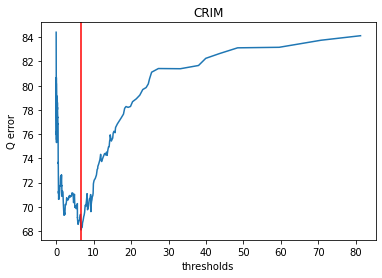

In [13]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
plt.plot(thresholds, variances)
plt.title('CRIM')
plt.xlabel("thresholds")
plt.ylabel("Q error")
plt.axvline(x=threshold_best, c='r')
plt.show()

### Задание 2.2 (3 балла)
Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод _predict_node.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- Выбор лучшего разбиения необходимо производить по критерию Джини
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку
- Ответ в листе: наиболее часто встречающийся класс в листе

In [14]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            if np.all(feature_vector == feature_vector[0]):
                continue
            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini < gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split =  (feature_vector < threshold_best)  # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                elif feature_type == "categorical":
                    # в данной реализации это| просто значение категории
                    threshold_best = threshold
                    split = (feature_vector == threshold_best)  # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            print('hi')
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])
        

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        if node['type'] == 'terminal':
            return node['class']
        else:
            if self._feature_types[node['feature_split']] == 'real':
                if x[node['feature_split']] < node['threshold']:
                    self._predict_node(x, node['left_child'])
                else:
                    self._predict_node(x, node['right_child'])
            elif self._feature_types[node['feature_split']] == 'categorical':
                if x[node['feature_split']] == node['category_split']:
                    self._predict_node(x, node['left_child'])
                else:
                    self._predict_node(x, node['right_child'])
            else:
                raise ValueError
                
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

### Задание 2.3 (1 балл)
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [20]:
students = pd.read_csv('students.csv')
print(f"Dataset shape: {students.shape}")
students.head()

Dataset shape: (258, 7)


,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [21]:
students.columns

Index(['Unnamed: 0', 'STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS'], dtype='object')

In [23]:
y_stud = students['UNS']
X_stud = students.drop([' UNS'], axis=1)

fig = plt.figure(figsize=(15, 8))
for feature in range(X_stud.shape[1]):
    thresholds, variances, threshold_best, variance_best = find_best_split(
        X_stud.iloc[:, feature].to_numpy(), 
        y_stud, 
        task="regression",
        feature_type="real"
    )
    plt.plot(thresholds, variances, label=X_stud.columns[feature])
    plt.xlabel("thresholds")
    plt.ylabel("Q error")
#     plt.axvline(x=threshold_best, c='r')
    #plt.show()
plt.legend()

AttributeError: 'float' object has no attribute 'sum'

<Figure size 1080x576 with 0 Axes>

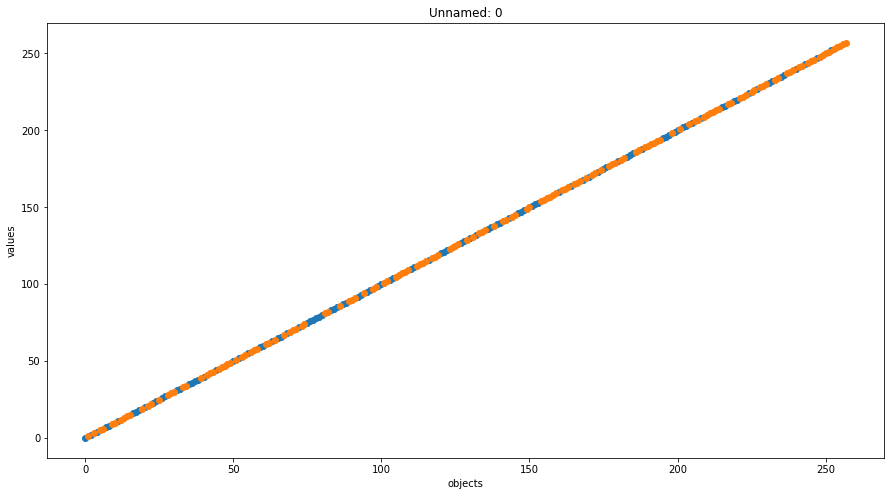

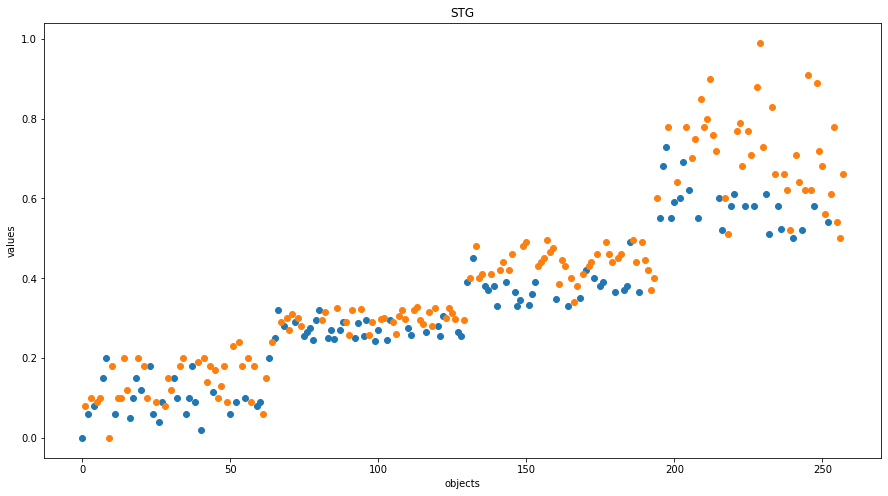

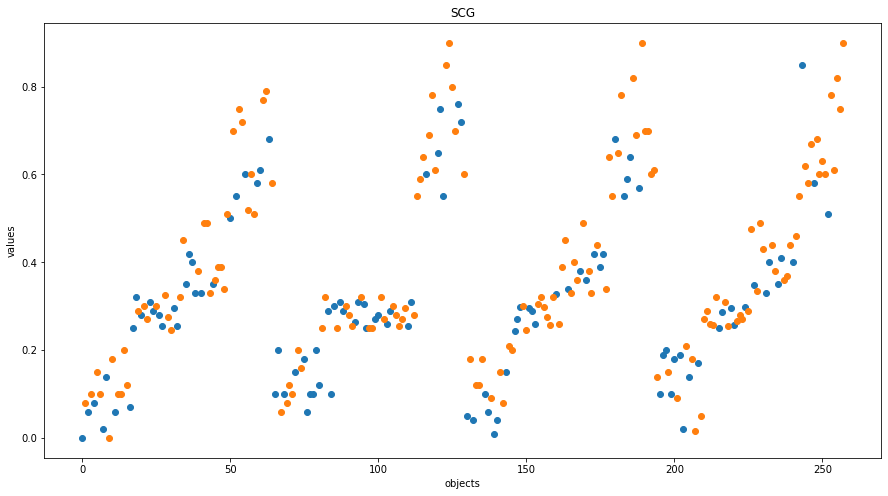

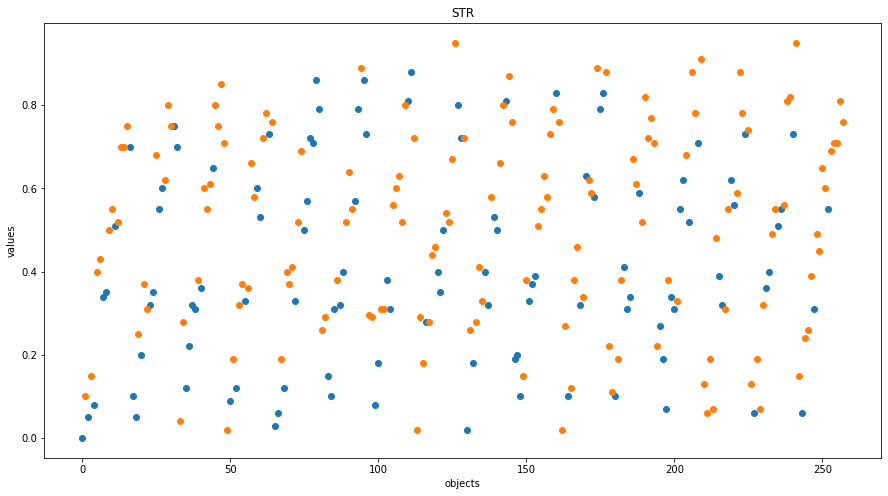

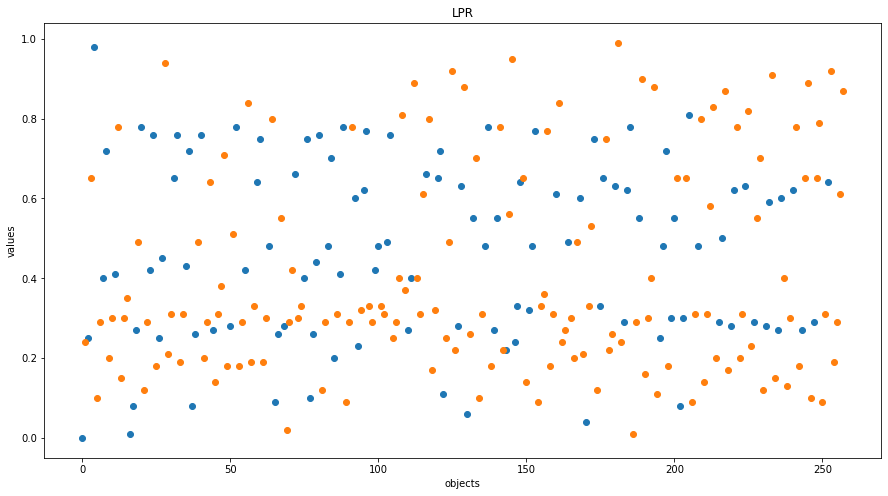

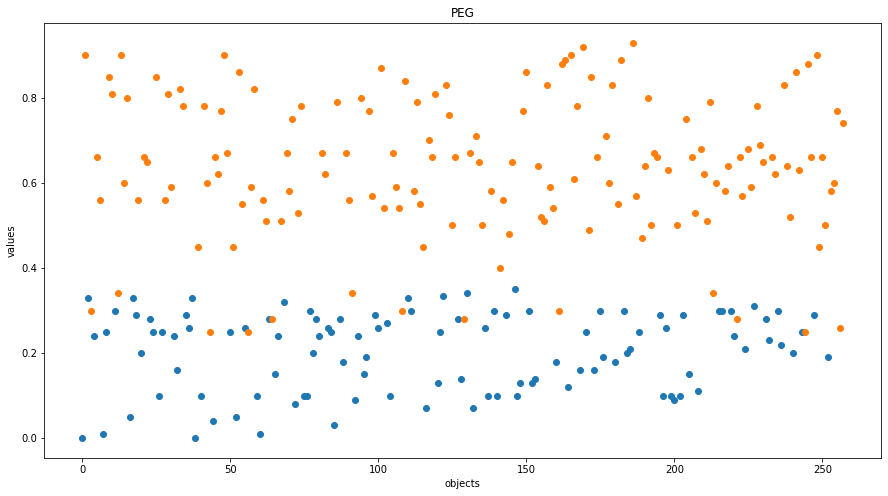

In [24]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
for feature in range(X_stud.shape[1]):
    fig = plt.figure(figsize=(15, 8))
    values_0 = X_stud.iloc[:, feature].where(y_stud == 0).dropna()
    values_1 = X_stud.iloc[:, feature].where(y_stud == 1).dropna()
    plt.scatter(values_0.index, values_0.values, label='class 0')
    plt.scatter(values_1.index, values_1.values, label='class 1')
    plt.xlabel("objects")
    plt.ylabel("values")
    plt.title(X_stud.columns[feature])
    plt.show()

### Задание 2.4 (1 балл)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Исходя из значений критерия Джини признак 'PEG' является лучшим признаком для разбиения. Это подтверждается визуальной оценкой scatter-графиков. Разделить выборку на два класса можно практически идеально.  
Вид кривой можно охарактеризовать так: при изменении порога можно видеть заметное уменьшение ошибки, а потом возрастание её (или наоборот, обход неважен), то есть достигается минимум при конкретном значении порога, а при остальных значениях ошибка больше.  
На кривых у признаков, у которых невозможно разделить выборку на два класса, ошибка колеблется примерно на одном уровне и не понижается при изменении порогов.

ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

### Задание 2.5 (1 балл)

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [26]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
mushrooms = pd.read_csv('agaricus-lepiota.data')

In [27]:
mushrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [30]:
le = LabelEncoder()

for column in mushrooms:
    mushrooms[column] = le.fit_transform(mushrooms[column])

In [31]:
mushrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [32]:
y = mushrooms['p']
X = mushrooms.drop(['p'], axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.5, random_state=42)

In [34]:
X_train[0]

array([ 5,  3,  5,  1,  5,  1,  0,  0, 10,  0,  0,  2,  2,  2,  7,  0,  2,
        2,  0,  7,  1,  6])

In [35]:
%%time
clf = DecisionTree(['categorical'] * X_train.shape[1])
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

CPU times: user 244 ms, sys: 0 ns, total: 244 ms
Wall time: 243 ms


In [36]:
pred

array([None, None, None, ..., None, None, None], dtype=object)

In [37]:
print('accuracy = ', accuracy_score(y_test, pred))

ValueError: Classification metrics can't handle a mix of binary and unknown targets

## Часть 3: бэггинг, случайный лес

В данной части будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [5]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [8]:
data = pd.read_csv('../input/diabets/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

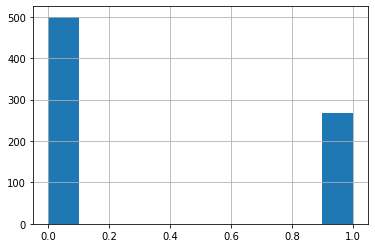

In [9]:
data['Outcome'].hist()
plt.show()

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

In [10]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
y = data['Outcome']
X = data.drop(['Outcome'], axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Задание 3.1 (1 балл)

Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [31]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50,
                  random_state=42)

In [32]:
pred = clf.predict(X_test)
print('accuracy:\t', accuracy_score(pred, y_test))
print('precision:\t', precision_score(pred, y_test))
print('recall:\t\t', recall_score(pred, y_test))
print('auc_roc:\t', roc_auc_score(pred, y_test))

accuracy:	 0.7489177489177489
precision:	 0.6625
recall:		 0.6309523809523809
auc_roc:	 0.7236394557823129


### Задание 3.2 (1 балл)

Теперь обучите Random Forest с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

In [33]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [34]:
pred = clf.predict(X_test)
print('accuracy:', accuracy_score(pred, y_test))
print('precision:', precision_score(pred, y_test))
print('recall:', recall_score(pred, y_test))
print('auc_roc:', roc_auc_score(pred, y_test))

accuracy: 0.7402597402597403
precision: 0.6625
recall: 0.6162790697674418
auc_roc: 0.7150360866078588


Bagging Classifier показал себя лучше по данным метрикам на конкретном разбиении.

### Задание 3.3 (1 балл)

Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров (можете сделать обычный перебор с обучением/тестированием в цикле):
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

In [35]:
%%time
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
fig = plt.figure(figsize=(15,8))
map_ = np.zeros([10, 10])
n_estimators = [10, 50, 100, 250, 400, 550, 750, 900, 1100, 1350]
min_samples_leaves = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i, n_estimator in enumerate(n_estimators):
    for j, min_samples_leaf in enumerate(min_samples_leaves):
        clf = RandomForestClassifier(n_estimators=n_estimator, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        auc_roc = roc_auc_score(pred, y_test)
        map_[i, j] = auc_roc

CPU times: user 1min 56s, sys: 613 ms, total: 1min 57s
Wall time: 1min 57s


<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'AUC-ROC')

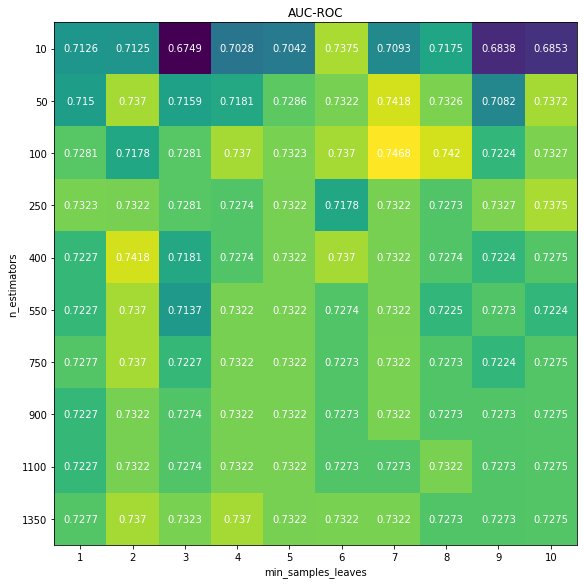

In [36]:
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(map_)
ax.set_xticks(np.arange(len(min_samples_leaves)))
ax.set_yticks(np.arange(len(n_estimators)))
# labeling respective list entries
ax.set_xticklabels(min_samples_leaves)
ax.set_yticklabels(n_estimators)
plt.ylabel('n_estimators')
plt.xlabel('min_samples_leaves')

for i in range(len(min_samples_leaves)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, round(map_[i, j], 4),
                       ha="center", va="center", color="w")
fig.tight_layout()
plt.title('AUC-ROC')

In [37]:
%%time
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
fig = plt.figure(figsize=(15,8))
map_ = np.zeros([10, 10])
n_estimators = [10, 50, 100, 250, 400, 550, 750, 900, 1100, 1350]
min_samples_leaves = [1, 3, 5, 10, 15, 20, 25, 30, 40, 50]
for i, n_estimator in enumerate(n_estimators):
    for j, min_samples_leaf in enumerate(min_samples_leaves):
        clf = RandomForestClassifier(n_estimators=n_estimator, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        auc_roc = roc_auc_score(pred, y_test)
        map_[i, j] = auc_roc

CPU times: user 1min 51s, sys: 690 ms, total: 1min 52s
Wall time: 1min 52s


<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'AUC-ROC')

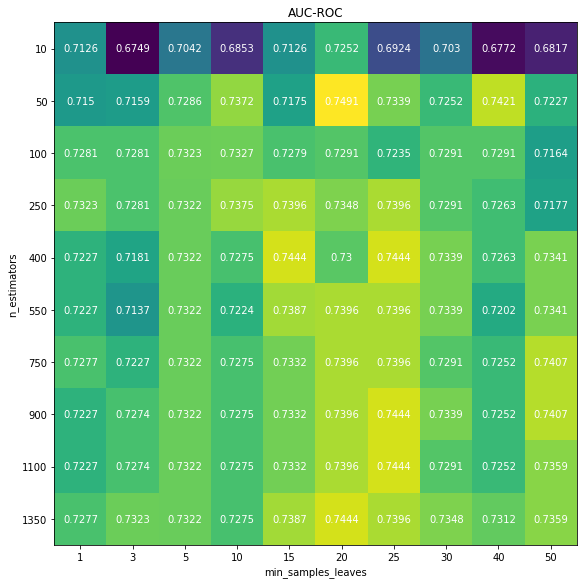

In [38]:
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(map_)
ax.set_xticks(np.arange(len(min_samples_leaves)))
ax.set_yticks(np.arange(len(n_estimators)))
# labeling respective list entries
ax.set_xticklabels(min_samples_leaves)
ax.set_yticklabels(n_estimators)
plt.ylabel('n_estimators')
plt.xlabel('min_samples_leaves')

for i in range(len(min_samples_leaves)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, round(map_[i, j], 4),
                       ha="center", va="center", color="w")
fig.tight_layout()
plt.title('AUC-ROC')

При малом количестве деревьев модели хуже, при увеличении их количества значительного роста нет (устанавливается примерно один уровень).

### Задание 3.4 (1 балл)

Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [39]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
clf_best = RandomForestClassifier(n_estimators=50, min_samples_leaf=20, random_state=42)
clf_best.fit(X_train, y_train)
f_importances = clf.feature_importances_

<BarContainer object of 8 artists>

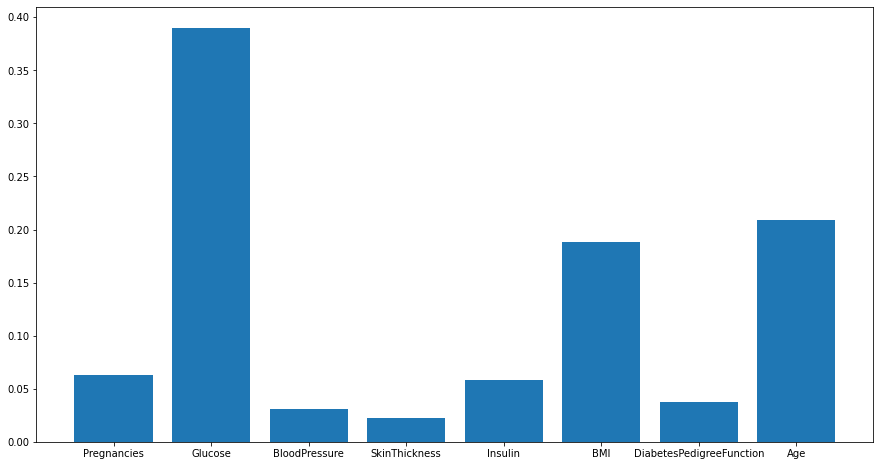

In [40]:
fig = plt.figure(figsize=(15, 8))
plt.bar(X.columns, f_importances)

Самым важным признаком для определения диабета оказался Glucose.